In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

In [2]:
def graficar(s: pd.Series, t, resc = None, linea_cero=False):
    fig, ax = plt.subplots(figsize=[8,4])
    s.plot(ax=ax)
    ax.set_title(t)
    if resc is not None:        
        y1, y2 = ax.get_ylim()
        resc1 = resc == 1
        ax.fill_between(resc1.index, y1=y1, y2=y2, where=resc1, facecolor='grey', alpha=0.4)
    if linea_cero:
        ax.axhline(y=0,color='grey',linestyle='--')

def graficar2(s1: pd.Series, t1,s2: pd.Series, t2, linea_cero=False):
    fig, ax = plt.subplots(1,2,figsize=[10,4])
    s1.plot(ax=ax[0])
    s2.plot(ax=ax[1])
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    if linea_cero:
        ax[0].axhline(y=0,color='grey',linestyle='--')
        ax[1].axhline(y=0,color='grey',linestyle='--')

def graficar_multiple(df):
    for col in df.columns:
        if col == 'Class':
            graficar(df[col], col)
            continue
        graficar(df[col],col,resc=df['Class'])

# Carga de datos
Se extrayeron los datos de [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/tags/series?t=monthly)

Indicadores Macroeconómicos

In [3]:
df = pd.read_csv('../data/PERU_DATA.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df['Recesion'] = df['Recesion'].astype('int')
df = df.rename(columns={'Recesion':'Class'})
df.head()

,PN02312FM,PN38705PM,PN02020AM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
DATE,,,,,,,,
1995-02-01,1272.226473,38.433894,44.739967,55.767947,31.035781,59.493583,42.826815,0
1995-03-01,1495.857345,38.961215,44.659303,59.344344,30.136709,70.994501,52.061686,0
1995-04-01,1650.980245,39.344815,80.052825,52.743337,29.452419,70.873138,45.182163,0
1995-05-01,1567.141857,39.673230,80.008829,63.550977,30.898029,72.091964,51.892059,0
1995-06-01,1452.243775,39.994072,69.848503,62.733200,32.893440,69.770364,47.712314,0


# Descripción

Características de dataset de macroeconomia

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 1995-02-01 to 2022-09-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PN02312FM  332 non-null    float64
 1   PN38705PM  332 non-null    float64
 2   PN02020AM  332 non-null    float64
 3   PN02028AM  332 non-null    float64
 4   PD37972BM  332 non-null    float64
 5   PD37974BM  332 non-null    float64
 6   PD37976BM  332 non-null    float64
 7   Class      332 non-null    int32  
dtypes: float64(7), int32(1)
memory usage: 22.0 KB


Metadatos del dataset

In [5]:
md = pd.read_csv('../data/PERU_METADATA.csv')
md

,Feature,Description
0,PN02312FM,Ingresos corrientes del gobierno central (mill...
1,PN38705PM,Índice de precios Lima Metropolitana (índice D...
2,PN02020AM,Producción manufacturera (índice 2007 = 100) -...
3,PN02028AM,Producción manufacturera (índice 2007 = 100) -...
4,PD37972BM,Indicadores de coyuntura - Volumen de exportac...
5,PD37974BM,Indicadores de coyuntura - Volumen de importac...
6,PD37976BM,Indicadores de coyuntura - Volumen de importac...


Estadisticas descriptivas del dataset

In [6]:
df.describe()

,PN02312FM,PN38705PM,PN02020AM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,5962.681531,69.824862,104.400445,96.893401,106.152020,136.997651,110.277013,0.117470
std,3728.593018,16.355042,29.822633,29.867365,53.145446,70.576452,50.474622,0.322465
min,1272.226473,38.433894,42.609802,44.000495,27.040935,40.847639,38.761128,0.000000
25%,2381.603673,56.971250,83.739169,64.365560,53.804463,70.525440,57.854372,0.000000
50%,5216.169214,69.185041,103.716917,104.606060,103.837984,114.370742,108.518908,0.000000
75%,8461.483993,83.963561,119.721245,124.955948,144.572937,209.385636,155.790121,0.000000
max,22599.104803,106.679849,211.517306,144.397027,264.058785,281.894625,216.507003,1.000000


Grafica de las caracteristicas

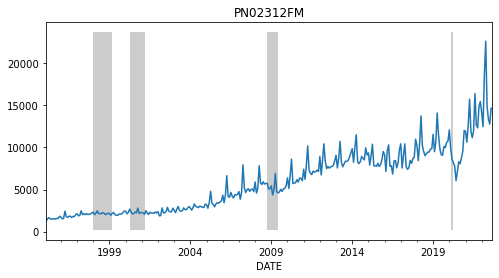

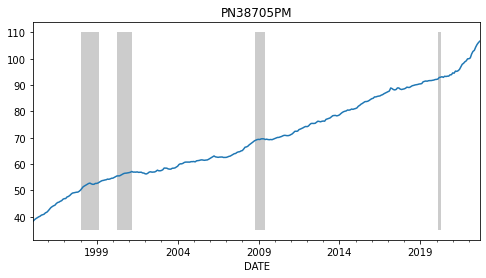

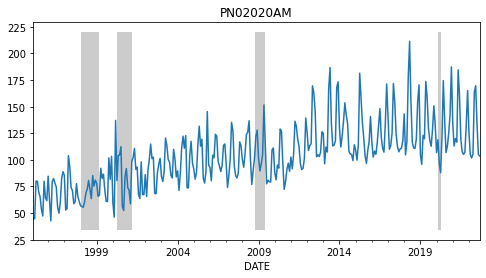

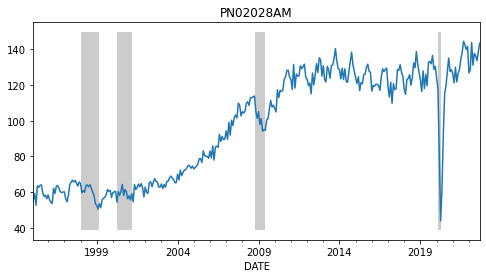

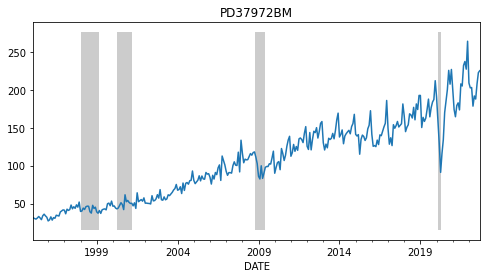

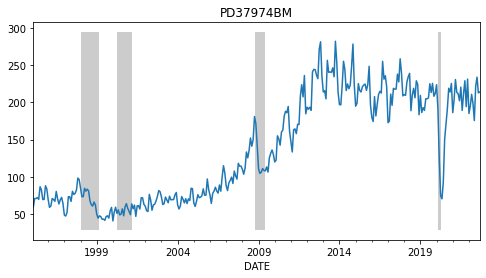

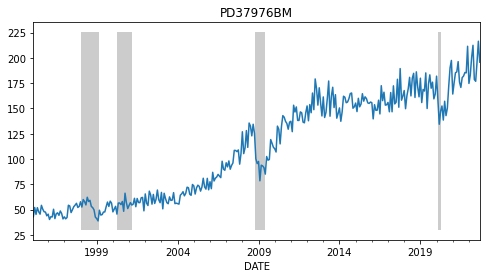

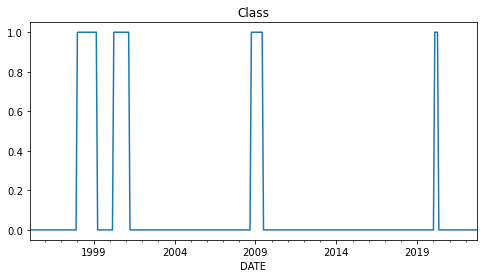

In [7]:
graficar_multiple(df)

# Preprocesamiento

## Ajuste Estacional

Segun lo anterior, se observa que presentan estacionalidad.
Se procede a realizar un ajuste estacional, descomponiendo la serie y eliminando 
su componente de estacionalidad.

In [8]:
for col in df.columns:
    if col == 'Class':
        continue
    res = STL(df[col], period = 12).fit()
    df[col] = res.trend

Resultados

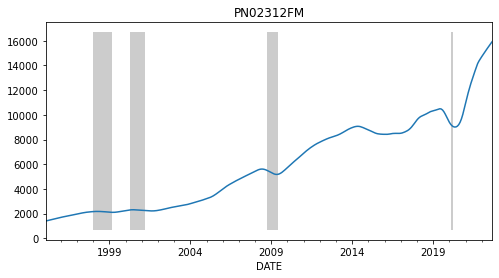

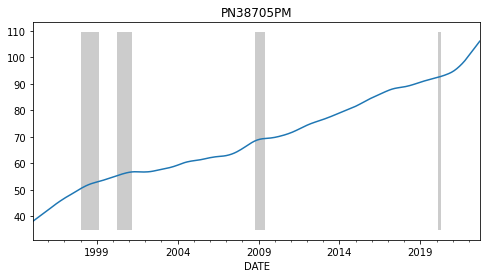

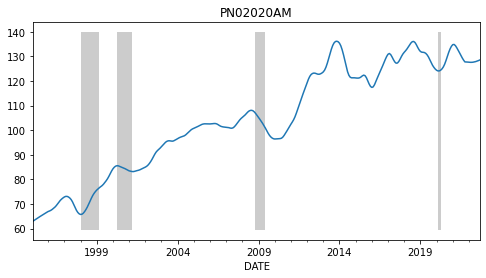

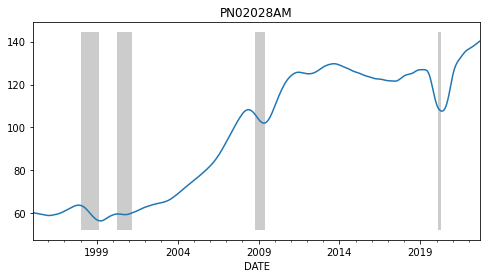

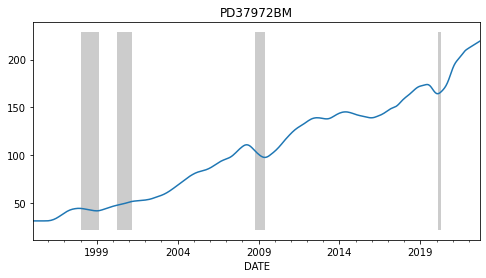

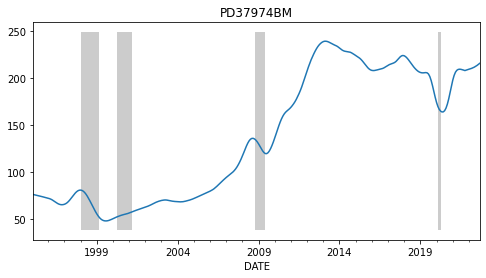

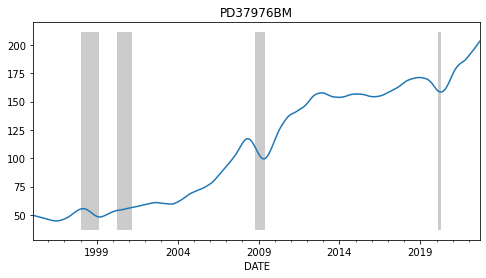

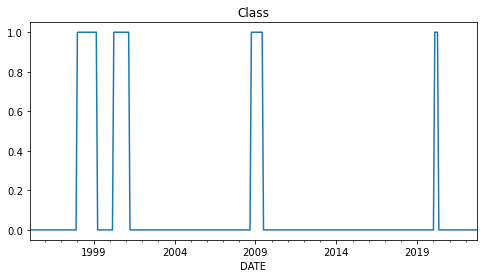

In [9]:
graficar_multiple(df)

## Transformaciones

Se transforma las series a variaciones segun la observacion anterior usando diferencia logaritmica

In [10]:
df_diff = df.copy()
for col in df_diff.columns:
    if col == 'Class':
        continue
    df_diff[col] = np.log(df_diff[col]) - np.log(df_diff[col].shift(1))
df_diff = df_diff.dropna()

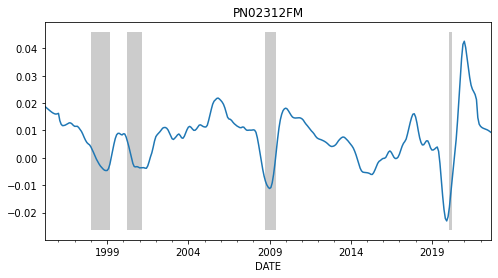

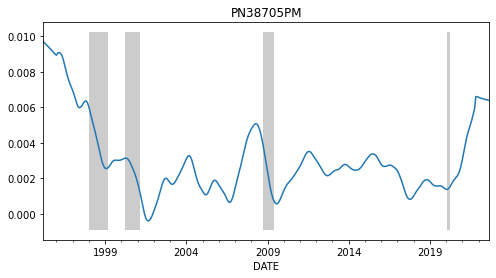

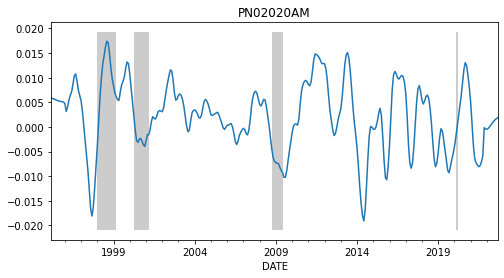

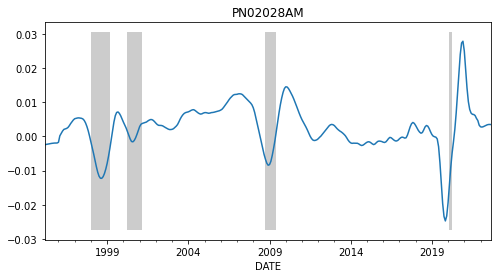

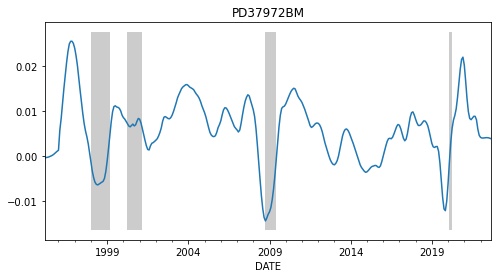

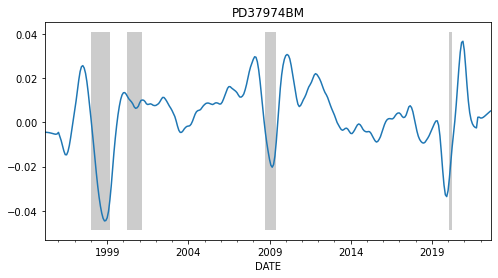

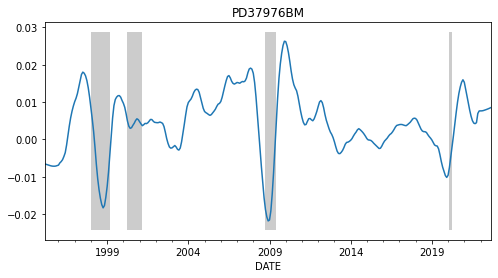

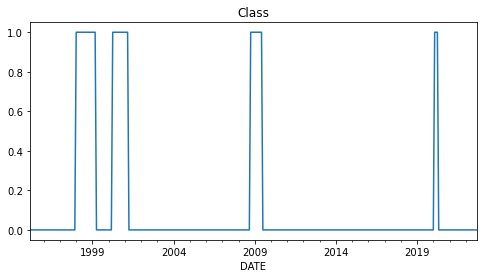

In [11]:
graficar_multiple(df_diff)

Completar datos interpolando

In [12]:
df_diff.head()

,PN02312FM,PN38705PM,PN02020AM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
DATE,,,,,,,,
1995-03-01,0.018757,0.009731,0.005855,-0.002390,-0.000309,-0.004451,-0.006579,0
1995-04-01,0.018362,0.009650,0.005762,-0.002311,-0.000265,-0.004446,-0.006674,0
1995-05-01,0.017922,0.009572,0.005655,-0.002235,-0.000201,-0.004494,-0.006794,0
1995-06-01,0.017489,0.009495,0.005537,-0.002158,-0.000108,-0.004590,-0.006922,0
1995-07-01,0.017076,0.009418,0.005422,-0.002082,0.000016,-0.004723,-0.007032,0


In [13]:
df_diff.describe()

,PN02312FM,PN38705PM,PN02020AM,PN02028AM,PD37972BM,PD37974BM,PD37976BM,Class
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.007333,0.003076,0.002147,0.002553,0.005870,0.003140,0.004260,0.117825
std,0.009396,0.002156,0.006948,0.006737,0.007171,0.014114,0.008570,0.322889
min,-0.023065,-0.000396,-0.019100,-0.024735,-0.014352,-0.044618,-0.021834,0.000000
25%,0.001821,0.001677,-0.001747,-0.001154,0.001794,-0.004155,-0.000763,0.000000
50%,0.007930,0.002582,0.002351,0.002729,0.006407,0.003949,0.004378,0.000000
75%,0.011984,0.003378,0.006768,0.006601,0.009957,0.010879,0.009684,0.000000
max,0.042614,0.009731,0.017409,0.027911,0.025603,0.036833,0.026307,1.000000


<AxesSubplot:xlabel='DATE'>

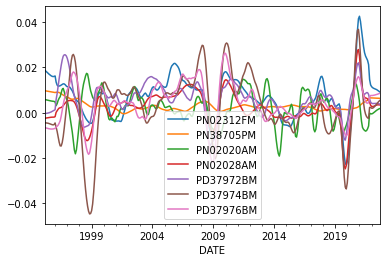

In [14]:
df_diff.drop(labels=['Class'],axis=1).plot()

array([[<AxesSubplot:title={'center':'PN02312FM'}>,
        <AxesSubplot:title={'center':'PN38705PM'}>,
        <AxesSubplot:title={'center':'PN02020AM'}>],
       [<AxesSubplot:title={'center':'PN02028AM'}>,
        <AxesSubplot:title={'center':'PD37972BM'}>,
        <AxesSubplot:title={'center':'PD37974BM'}>],
       [<AxesSubplot:title={'center':'PD37976BM'}>,
        <AxesSubplot:title={'center':'Class'}>, <AxesSubplot:>]],
      dtype=object)

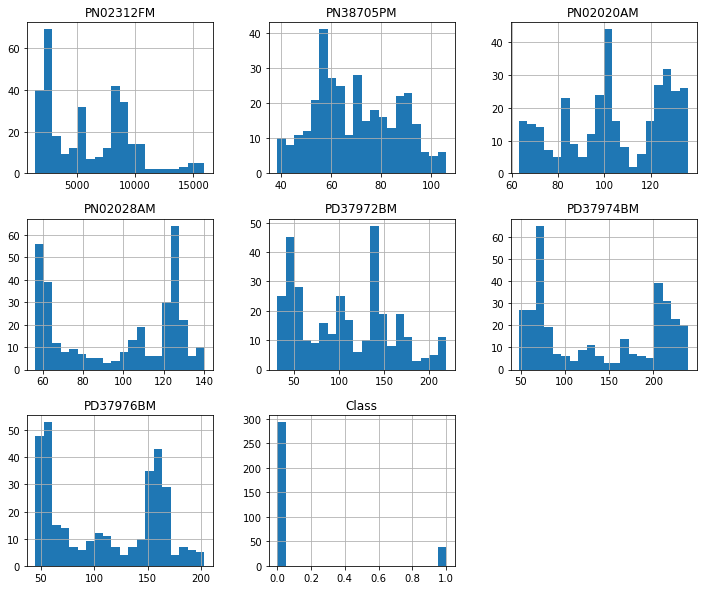

In [15]:
df.hist(figsize=[12,10],bins=20)

array([[<AxesSubplot:title={'center':'PN02312FM'}>,
        <AxesSubplot:title={'center':'PN38705PM'}>,
        <AxesSubplot:title={'center':'PN02020AM'}>],
       [<AxesSubplot:title={'center':'PN02028AM'}>,
        <AxesSubplot:title={'center':'PD37972BM'}>,
        <AxesSubplot:title={'center':'PD37974BM'}>],
       [<AxesSubplot:title={'center':'PD37976BM'}>,
        <AxesSubplot:title={'center':'Class'}>, <AxesSubplot:>]],
      dtype=object)

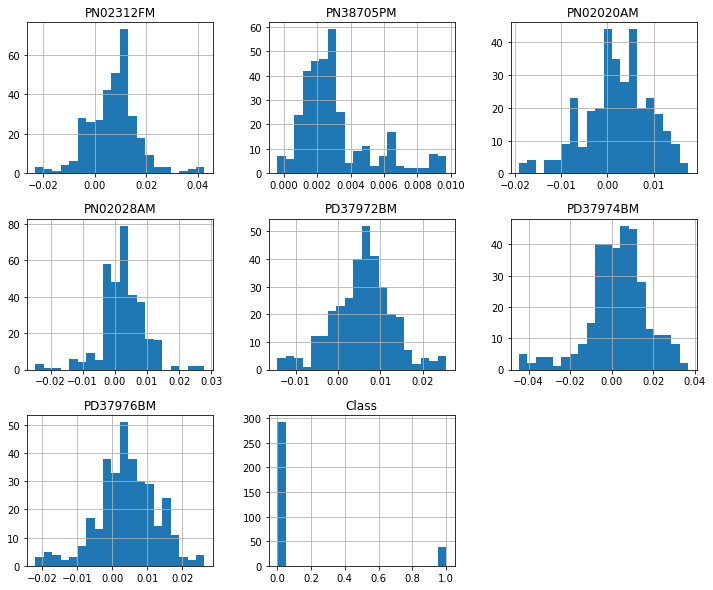

In [16]:
df_diff.hist(figsize=[12,10], bins=20)

In [17]:
df_diff.to_csv("../data/PERU_DATA_DIFF.csv")